In [15]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import init_notebook_mode, iplot
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


tf.random.set_seed(1)
np.random.seed(1)

pio.renderers.default = "notebook_connected"




In [16]:
train = pd.read_csv('/home/user/train.csv', parse_dates=['date'])
test = pd.read_csv('/home/user/test1.csv', parse_dates=['date'])

In [17]:
train.describe()

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

In [18]:
train.head()

date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10

In [19]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


In [20]:
lag_size = (test['date'].max().date() - train['date'].max().date()).days
print('Max date from train set: %s' % train['date'].max().date())
print('Max date from test set: %s' % test['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2017-12-31
Max date from test set: 2018-03-31
Forecast lag size 90


In [21]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [22]:
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

In [23]:
store_daily_sales_sc = []
for store in store_daily_sales['store'].unique():
    current_store_daily_sales = store_daily_sales[(store_daily_sales['store'] == store)]
    store_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['date'], y=current_store_daily_sales['sales'], name=('Store %s' % store)))

layout = go.Layout(title='Store daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=store_daily_sales_sc, layout=layout)
iplot(fig)

In [24]:
item_daily_sales_sc = []
for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['item'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['sales'], name=('Item %s' % item)))

layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

In [25]:
train = train[(train['date'] >= '2017-01-01')]

In [26]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

item  store       date  sales
0     1      1 2017-01-01   19.0
1     1      1 2017-01-02   15.0
2     1      1 2017-01-03   10.0
3     1      1 2017-01-04   16.0
4     1      1 2017-01-05   14.0

In [27]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [28]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

item(t-29)  store(t-29)  sales(t-29)  item(t-28)  store(t-28)  \
29         1.0          1.0         19.0         1.0          1.0   
30         1.0          1.0         15.0         1.0          1.0   
31         1.0          1.0         10.0         1.0          1.0   
32         1.0          1.0         16.0         1.0          1.0   
33         1.0          1.0         14.0         1.0          1.0   

    sales(t-28)  item(t-27)  store(t-27)  sales(t-27)  item(t-26)  ...  \
29         15.0         1.0          1.0         10.0         1.0  ...   
30         10.0         1.0          1.0         16.0         1.0  ...   
31         16.0         1.0          1.0         14.0         1.0  ...   
32         14.0         1.0          1.0         24.0         1.0  ...   
33         24.0         1.0          1.0         14.0         1.0  ...   

    sales(t-2)  item(t-1)  store(t-1)  sales(t-1)  item(t)  store(t)  \
29        16.0        1.0         1.0        24.0        1         1   
30        24.0        1.0         1.0         9.0        1         1   
31         9.0        1.0         1.0        17.0        1         1   
32        17.0        1.0         1.0        15.0        1         1   
33        15.0        1.0         1.0        17.0        1         1   

    sales(t)  item(t+90)  store(t+90)  sales(t+90)  
29       9.0         1.0          1.0         33.0  
30      17.0         1.0          1.0         15.0  
31      15.0         1.0          1.0         21.0  
32      17.0         1.0          1.0         29.0  
33      24.0         1.0          1.0         19.0  

[5 rows x 93 columns]

In [29]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

In [30]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

In [31]:
# Label
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (100746, 30)
Validation set shape (67164, 30)


sales(t-29)  sales(t-28)  sales(t-27)  sales(t-26)  sales(t-25)  \
18801          97.0        111.0         90.0        115.0        123.0   
160385         38.0         43.0         43.0         55.0         47.0   
73123          55.0         45.0         41.0         46.0         47.0   
90428         139.0        157.0         85.0         99.0        136.0   
167151         86.0         58.0         88.0         87.0        114.0   

        sales(t-24)  sales(t-23)  sales(t-22)  sales(t-21)  sales(t-20)  ...  \
18801          70.0         99.0         74.0        107.0        108.0  ...   
160385         51.0         38.0         41.0         37.0         59.0  ...   
73123          36.0         30.0         46.0         41.0         42.0  ...   
90428         110.0        121.0        123.0        147.0         91.0  ...   
167151        113.0         64.0         76.0         87.0         81.0  ...   

        sales(t-9)  sales(t-8)  sales(t-7)  sales(t-6)  sales(t-5)  \
18801         85.0        95.0       123.0       109.0       127.0   
160385        41.0        38.0        38.0        53.0        53.0   
73123         38.0        36.0        40.0        50.0        44.0   
90428        130.0       128.0       128.0        95.0       116.0   
167151        55.0        66.0        59.0        53.0        63.0   

        sales(t-4)  sales(t-3)  sales(t-2)  sales(t-1)  sales(t)  
18801        132.0        87.0       101.0       102.0     114.0  
160385        45.0        44.0        24.0        30.0      37.0  
73123         44.0        40.0        38.0        50.0      49.0  
90428        110.0       117.0       118.0       129.0     132.0  
167151        59.0        77.0        39.0        56.0      62.0  

[5 rows x 30 columns]

In [32]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [33]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3100      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [34]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
3149/3149 - 12s - loss: 418.3064 - val_loss: 382.0822 - 12s/epoch - 4ms/step
Epoch 2/40
3149/3149 - 11s - loss: 367.6151 - val_loss: 364.3323 - 11s/epoch - 3ms/step
Epoch 3/40
3149/3149 - 9s - loss: 359.0656 - val_loss: 374.1705 - 9s/epoch - 3ms/step
Epoch 4/40
3149/3149 - 10s - loss: 356.9195 - val_loss: 383.2238 - 10s/epoch - 3ms/step
Epoch 5/40
3149/3149 - 10s - loss: 355.2057 - val_loss: 354.4117 - 10s/epoch - 3ms/step
Epoch 6/40
3149/3149 - 11s - loss: 353.7918 - val_loss: 354.4599 - 11s/epoch - 3ms/step
Epoch 7/40
3149/3149 - 10s - loss: 352.0267 - val_loss: 359.9826 - 10s/epoch - 3ms/step
Epoch 8/40
3149/3149 - 11s - loss: 350.7605 - val_loss: 350.0577 - 11s/epoch - 3ms/step
Epoch 9/40
3149/3149 - 11s - loss: 350.4634 - val_loss: 349.1276 - 11s/epoch - 3ms/step
Epoch 10/40
3149/3149 - 11s - loss: 348.8550 - val_loss: 348.8945 - 11s/epoch - 4ms/step
Epoch 11/40
3149/3149 - 10s - loss: 348.2956 - val_loss: 349.0804 - 10s/epoch - 3ms/step
Epoch 12/40
3149/3149 - 10s - lo

In [35]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (100746, 30, 1)
Validation set shape (67164, 30, 1)


In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam

# Define your model architecture
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))  # Replace input_shape1 and input_shape2 with your input shape
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))

# Define the legacy optimizer
optimizer = LegacyAdam(learning_rate=0.01)  # Adjust the learning rate as needed

# Compile the model with the legacy optimizer
model_cnn.compile(loss='mse', optimizer=optimizer)

# Display model summary
model_cnn.summary()

# Print the names and shapes of trainable variables
print("Trainable Variables:")
for var in model_cnn.trainable_variables:
    print(f"Variable: {var.name}, Shape: {var.shape}")

# Training data (X_train_series and Y_train) and validation data (X_valid_series and Y_valid) should be defined

# Train the model
epochs = 40  # Adjust the number of epochs as needed
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                44850     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 45,093
Trainable params: 45,093
Non-trainable params: 0
__________________________________________________

In [37]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()


# Define the legacy optimizer
optimizer = LegacyAdam(learning_rate=0.01)  # Adjust the learning rate as needed

# Compile the model with the legacy optimizer
model_lstm.compile(loss='mse', optimizer=optimizer)

# Display model summary
model_lstm.summary()

# Print the names and shapes of trainable variables
print("Trainable Variables:")
for var in model_lstm.trainable_variables:
    print(f"Variable: {var.name}, Shape: {var.shape}")

# Training data (X_train_series and Y_train) and validation data (X_valid_series and Y_valid) should be defined

# Train the LSTM model
epochs = 40  # Adjust the number of epochs as needed
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainab

In [38]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (100746, 2, 15, 1)
Validation set shape (67164, 2, 15, 1)


In [39]:

model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))_sub)

# Define the legacy optimizer
optimizer = LegacyAdam(learning_rate=0.01)  # Adjust the learning rate as needed

# Compile the model with the legacy optimizer
model_cnn_lstm.compile(loss='mse', optimizer=optimizer)

# Display model summary
model_cnn_lstm.summary()

# Print the names and shapes of trainable variables
print("Trainable Variables:")
for var in model_cnn_lstm.trainable_variables:
    print(f"Variable: {var.name}, Shape: {var.shape}")

# Training data (X_train_series_sub and Y_train) and validation data (X_valid_series_sub and Y_valid) should be defined

# Train the CNN-LSTM model
epochs = 40  # Adjust the number of epochs as needed
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 15, 64)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 7, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 448)        0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 50)                99800     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                      

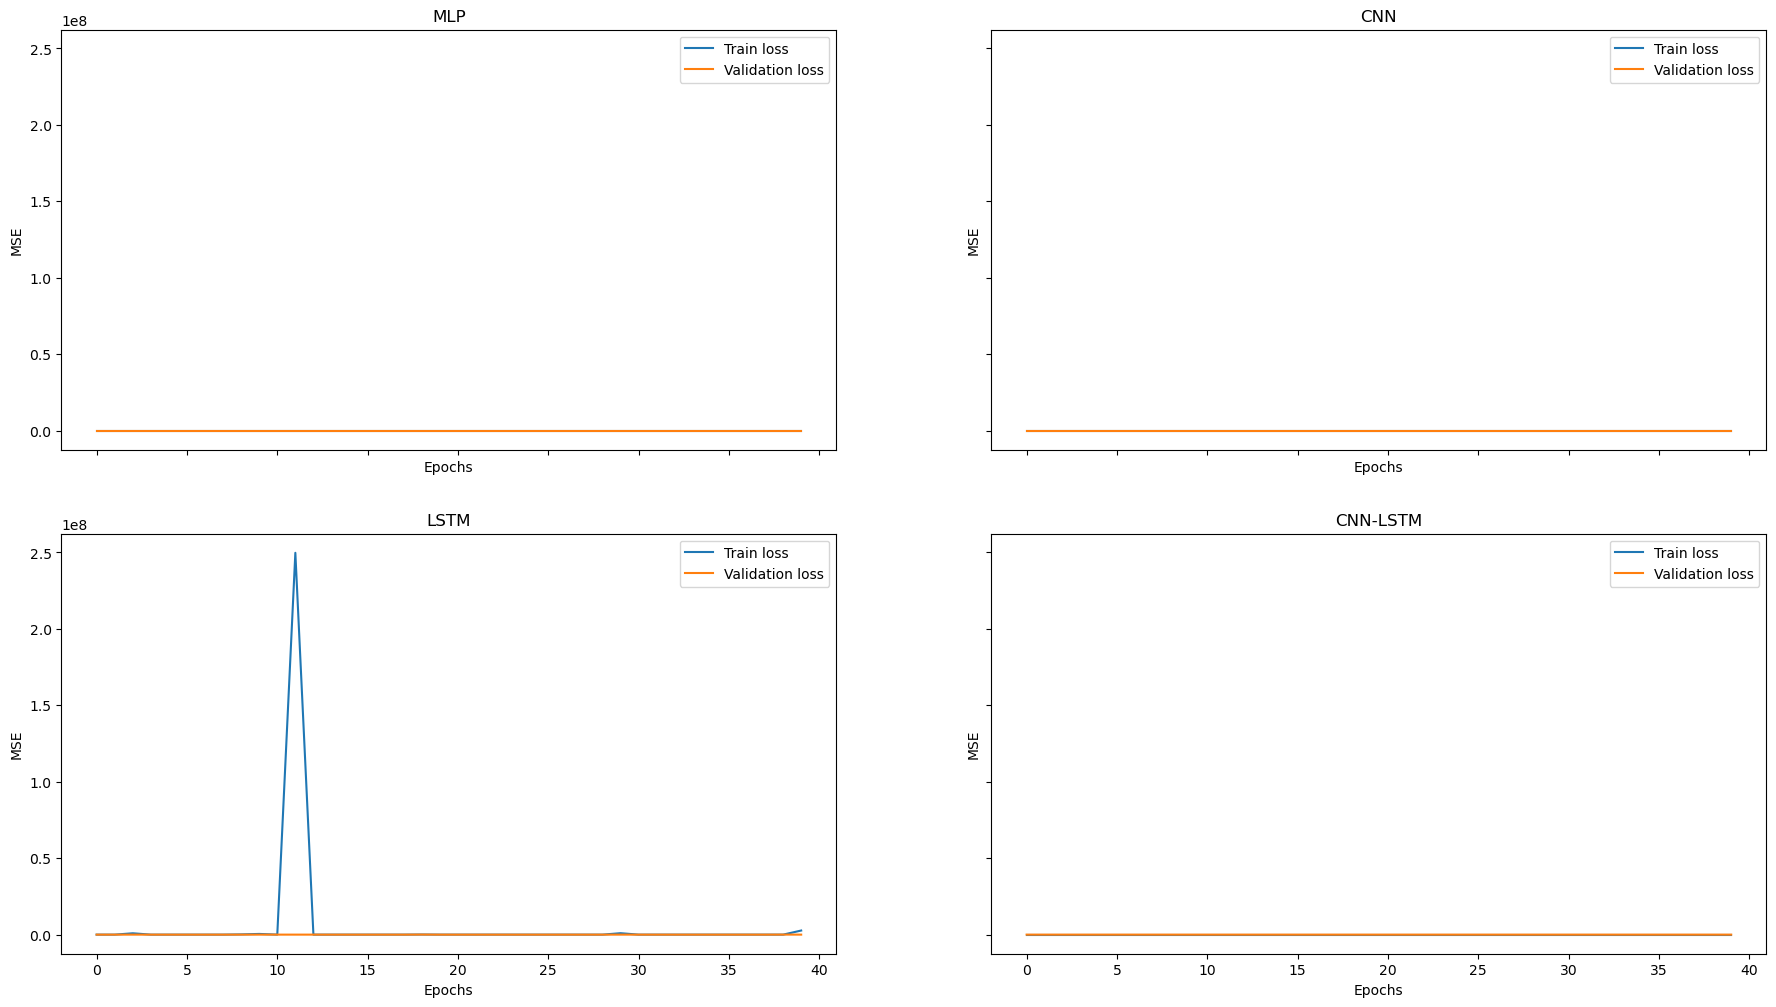

In [40]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss') 
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

In [41]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

2099/2099 [==============================] - 3s 1ms/step
Train rmse: 18.303212356628723
Validation rmse: 18.451820778465173


In [42]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

2099/2099 [==============================] - 7s 3ms/step
Train rmse: 19.038561202321574
Validation rmse: 19.063349254363438


In [44]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred))) 

2099/2099 [==============================] - 6s 3ms/step
Train rmse: 19.880457960553866
Validation rmse: 19.875946710140166
